The code provided performs a time series analysis for Bitcoin (BTC) price prediction using a recurrent neural network (RNN) model. Here's a concise summary of the code:

1. Ticker Symbols: The `assets` list is defined with the ticker symbol of BTC-USD.

2. Data Download: The minute-by-minute data for the specified day is downloaded using the Yahoo Finance API (`yf.download()` function) and stored in the `data` DataFrame.

3. Data Preprocessing: The `Close` price is extracted from the downloaded data and stored in a separate DataFrame. The `MinMaxScaler` is applied to scale the `Close` prices.

4. Train-Test Split: The data is split into training and testing sets using the `get_train_test_sets()` function. The `x_train`, `y_train`, `x_test`, and `y_test` variables store the input and output data for training and testing.

5. Model Architecture: A 3-layer LSTM RNN model is built using the Keras Sequential API. Bidirectional LSTM layers, dropout regularization, and dense layers are added to the model.

6. Model Compilation and Training: The model is compiled with the mean squared error loss and the Adam optimizer. It is then trained on the training data for a specified number of epochs.

7. Model Evaluation: The loss history is plotted using Matplotlib to visualize the model's performance during training.

8. Prediction and Inversion: The trained model is used to generate predictions (`y_pred`) on the testing data. The scaler is inverted to obtain the actual and predicted price values (`y_test_orig` and `y_pred_orig`).

9. Visualization: Matplotlib is used to plot the actual and predicted prices, as well as the historical prices, for better visualization.

10. Future Prediction: The model is used to make future predictions by iterating through the last input data (`x_test[-1]`) and appending the predicted values to the `predictions` list.

11. Final Visualization: The actual prices, predicted prices, and future predicted prices are plotted to visualize the BTC daily prices.

This code segment provides a comprehensive analysis of Bitcoin price prediction using an LSTM RNN model. It demonstrates data preprocessing, model building, training, evaluation, and visualization for accurate and future price forecasting.

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


def split_into_sequences(data, seq_len):
    n_seq = len(data) - seq_len + 1
    return np.array([data[i:(i+seq_len)] for i in range(n_seq)])

def get_train_test_sets(data, seq_len, train_frac):
    sequences = split_into_sequences(data, seq_len)
    n_train = int(sequences.shape[0] * train_frac)
    x_train = sequences[:n_train, :-1, :]
    y_train = sequences[:n_train, -1, :]
    x_test = sequences[n_train:, :-1, :]
    y_test = sequences[n_train:, -1, :]
    return x_train, y_train, x_test, y_test

[*********************100%***********************]  1 of 1 completed
Epoch 1/10
45/45 [==============================] - 8s 36ms/step - loss: 0.2701 - val_loss: 0.0051
Epoch 2/10
45/45 [==============================] - 0s 7ms/step - loss: 0.1181 - val_loss: 0.0205
Epoch 3/10
45/45 [==============================] - 0s 7ms/step - loss: 0.0754 - val_loss: 0.0157
Epoch 4/10
45/45 [==============================] - 0s 7ms/step - loss: 0.0570 - val_loss: 0.0093
Epoch 5/10
45/45 [==============================] - 0s 7ms/step - loss: 0.0347 - val_loss: 0.0037
Epoch 6/10
45/45 [==============================] - 0s 7ms/step - loss: 0.0156 - val_loss: 0.0016
Epoch 7/10
45/45 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0013
Epoch 8/10
45/45 [==============================] - 0s 7ms/step - loss: 0.0078 - val_loss: 0.0014
Epoch 9/10
45/45 [==============================] - 0s 7ms/step - loss: 0.0077 - val_loss: 0.0014
Epoch 10/10
45/45 [=============================

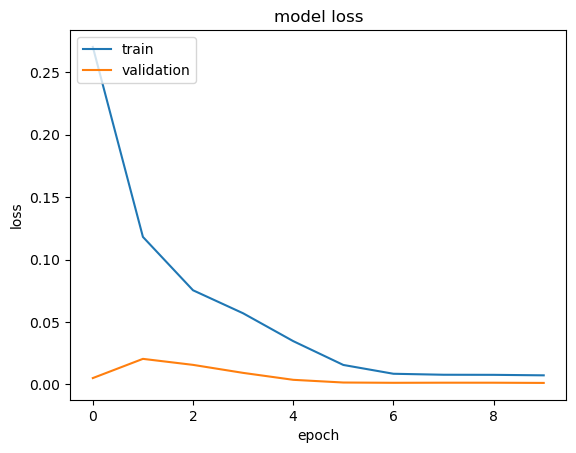

7/7 [==============================] - 1s 3ms/step


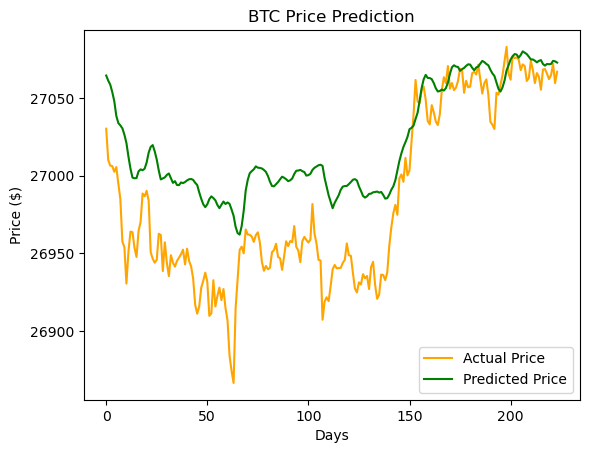

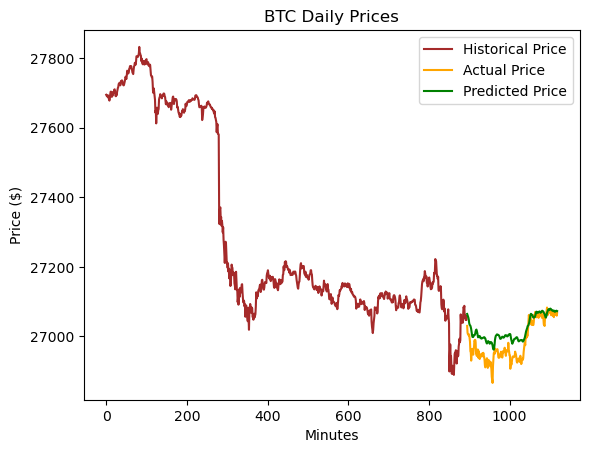

1/1 [==============================] - 0s 19ms/step


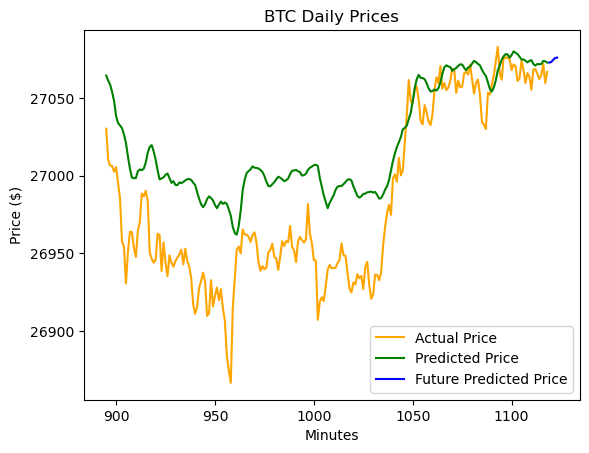

In [3]:
# Ticker symbols
assets = ['BTC-USD']


# Specify the desired day
start_date = datetime(2023, 5, 28)
end_date = datetime(2023, 5, 29)


# Download minute-by-minute data for the specified day
data = yf.download(assets, period='1d', interval='1m')
#data = yf.download(assets, start=start_date, end=end_date, interval = '1m')
data = data.Close


data = pd.DataFrame(data)



scaler = MinMaxScaler()
# fit the format of the scaler -> convert shape from (1000, ) -> (1000, 1)
close_price = data.Close.values.reshape(-1, 1)
scaled_close = scaler.fit_transform(close_price)


seq_len = 6

x_train, y_train, x_test, y_test = get_train_test_sets(scaled_close, seq_len, train_frac=0.8)


from tensorflow import keras
from tensorflow.keras.layers import Bidirectional, Dropout, Activation, Dense, LSTM
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.models import Sequential

# fraction of the input to drop; helps prevent overfitting
dropout = 0.2
window_size = seq_len - 1

# build a 3-layer LSTM RNN
model = keras.Sequential()

model.add(
    LSTM(window_size, return_sequences=True, 
         input_shape=(window_size, x_train.shape[-1]))
)

model.add(Dropout(rate=dropout))

# Bidirectional allows for training of sequence data forwards and backwards
model.add(
    Bidirectional(LSTM((window_size * 2), return_sequences=True)
)) 

model.add(Dropout(rate=dropout))
model.add(
    Bidirectional(LSTM(window_size, return_sequences=False))
) 

model.add(Dense(units=1))
# linear activation function: activation is proportional to the input
model.add(Activation('linear'))




batch_size = 16

model.compile(
    loss='mean_squared_error',
    optimizer='adam'
)

history = model.fit(
    x_train,
    y_train,
    epochs=10,
    batch_size=batch_size,
    shuffle=False,
    validation_split=0.2
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Generate predictions using the trained model
y_pred = model.predict(x_test)

# Invert the scaler to get the absolute price data
y_test_orig = scaler.inverse_transform(y_test)
y_pred_orig = scaler.inverse_transform(y_pred)

# Plot the predicted and actual prices
plt.plot(y_test_orig, label='Actual Price', color='orange')
plt.plot(y_pred_orig, label='Predicted Price', color='green')

plt.title('BTC Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price ($)')
plt.legend(loc='best')

plt.show()


# plot for whole range of data
plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Price')

plt.title('BTC Daily Prices')
plt.xlabel('Minutes')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


predictions = []
for i in range(5):
    x_pred = np.expand_dims(x_test[-1], axis=0)
    y_pred = model.predict(x_pred)
    predictions.append(y_pred)
    x_pred[:, :-1, :] = x_pred[:, 1:, :]
    x_pred[:, -1, :] = y_pred
    

reshaped_predictions = np.array(predictions).flatten().reshape(-1,1)

# plot for whole range of data
#plt.plot(np.arange(0, len(y_train)), scaler.inverse_transform(y_train), color='brown', label='Historical Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test_orig)), y_test_orig, color='orange', label='Actual Price')
plt.plot(np.arange(len(y_train), len(y_train) + len(y_pred_orig)), y_pred_orig, color='green', label='Predicted Price')
plt.plot(np.arange(len(y_train) + len(y_pred_orig), 
                   len(y_train) + len(y_pred_orig)+len(predictions)), 
                     scaler.inverse_transform(np.array(predictions).flatten().reshape(-1,1)), color='blue', label='Future Predicted Price')

plt.title('BTC Daily Prices')
plt.xlabel('Minutes')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

